# Rozpoznawanie gestów z akcelerometru – CNN-MLP

In [1]:
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.4 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sprawdzenie dostępności GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Urządzenie treningowe: {device}')


Urządzenie treningowe: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
from pathlib import Path

zip_path = '/content/drive/MyDrive/Colab Notebooks/data_ADXL345.zip'
image_path = ""

with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)

Unzipping data...


In [5]:
# 4. Parametry i lista gestów
DATA_FOLDER = '/content/data'
GESTURES = [
    "przesuniecie_w_prawo", "przesuniecie_w_lewo",
    "przesuniecie_w_gore", "przesuniecie_w_dol",
    "okrag_zgodnie_z_ruchem_wskazowek", "okrag_przeciwnie_do_ruchu_wskazowek",
    "litera_Z", "litera_V"
]
SEQUENCE_LENGTH = 80
OVERLAP_RATIO = 0.9
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 50


In [6]:
# 5. Przygotowanie Dataset
class GestureDataset(Dataset):
    def __init__(self, sequences, labels):
        self.X = torch.FloatTensor(sequences)
        self.y = torch.LongTensor(labels)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [42]:
# # 6. Definicja modelu CNN-LSTM
# class CNN_LSTM(nn.Module):
#     def __init__(self, in_channels=3, hidden_size=64, n_classes=len(GESTURES)):
#         super().__init__()
#         # CNN
#         self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
#         self.bn1   = nn.BatchNorm1d(32)
#         self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
#         self.bn2   = nn.BatchNorm1d(64)
#         self.pool  = nn.MaxPool1d(2)
#         # LSTM
#         self.lstm  = nn.LSTM(64, hidden_size, batch_first=True, dropout=0.2)
#         # FC
#         self.fc1   = nn.Linear(hidden_size, 32)
#         self.dropout = nn.Dropout(0.3)
#         self.fc2   = nn.Linear(32, n_classes)
#         self.relu  = nn.ReLU()
#     def forward(self, x):
#         # x: (batch, seq_len, features) -> (batch, features, seq_len)
#         x = x.transpose(1,2)
#         x = self.pool(self.relu(self.bn1(self.conv1(x))))
#         x = self.pool(self.relu(self.bn2(self.conv2(x))))
#         # (batch, features, seq) -> (batch, seq, features)
#         x = x.transpose(1,2)
#         # LSTM
#         out, _ = self.lstm(x)
#         last = out[:,-1,:]                  # ostatni krok
#         x = self.relu(self.fc1(last))
#         x = self.dropout(x)
#         return self.fc2(x)


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, n_classes=len(GESTURES)):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        # Po trzech poolingach: 80 / 2 / 2 / 2 = 10
        self.fc1 = nn.Linear(128 * 10, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        # Wejście już w formacie [batch, channels, length]
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        x = x.flatten(1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


In [8]:
# 7. Funkcja ładowania i tworzenia sekwencji
def load_sequences(folder):
    scaler = StandardScaler()
    seqs, labs = [], []

    for idx, label in enumerate(GESTURES):
        files = [f for f in os.listdir(folder) if f.startswith(label) and f.endswith('.csv')]

        for fn in files:
            df = pd.read_csv(os.path.join(folder, fn))
            arr = df[['acc_x','acc_y','acc_z']].values
            if len(arr) < SEQUENCE_LENGTH: continue
            arr = scaler.fit_transform(arr)
            step = int(SEQUENCE_LENGTH * (1 - OVERLAP_RATIO))

            for start in range(0, len(arr)-SEQUENCE_LENGTH+1, step):
                # seqs.append(arr[start:start+SEQUENCE_LENGTH])
                seq = arr[start:start+SEQUENCE_LENGTH].T  # Transpozycja!
                seqs.append(seq)
                labs.append(idx)
    print(f'Utworzono {len(seqs)} sekwencji, rozkład gestów: {Counter(labs)}')
    return np.array(seqs), np.array(labs)

# Załaduj dane
X, y = load_sequences(DATA_FOLDER)


Utworzono 28928 sekwencji, rozkład gestów: Counter({2: 3644, 3: 3637, 4: 3635, 6: 3620, 0: 3618, 5: 3606, 7: 3603, 1: 3565})


In [9]:
# 8. Podział na zbiory i DataLoadery
dataset = GestureDataset(X, y)
n_train = int(0.8 * len(dataset))
n_val   = len(dataset) - n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
print(f'Train: {len(train_ds)}, Val: {len(val_ds)}')


Train: 23142, Val: 5786


In [10]:
# 9. Inicjalizacja modelu, optymalizatora, funkcji straty
# model = CNN_LSTM().to(device)
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


In [47]:
# 10. Pętla trenowania i walidacji
best_acc = 0
history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, EPOCHS+1):
    # trening
    model.train()
    tloss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        tloss += loss.item()
    # walidacja
    model.eval()
    vloss, correct, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            vloss += criterion(preds, yb).item()
            _, mx = preds.max(1)
            correct += (mx==yb).sum().item()
            total   += yb.size(0)
    # wyniki
    train_loss = tloss/len(train_loader)
    val_loss   = vloss/len(val_loader)
    val_acc    = correct/total*100
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    print(f'E{epoch:02d}/{EPOCHS}  TrainLoss:{train_loss:.4f}  ValLoss:{val_loss:.4f}  ValAcc:{val_acc:.2f}%')


E01/50  TrainLoss:0.6806  ValLoss:0.3524  ValAcc:88.26%
E02/50  TrainLoss:0.4293  ValLoss:0.2754  ValAcc:90.53%
E03/50  TrainLoss:0.3737  ValLoss:0.2520  ValAcc:91.46%
E04/50  TrainLoss:0.3228  ValLoss:0.2408  ValAcc:91.65%
E05/50  TrainLoss:0.3018  ValLoss:0.2400  ValAcc:91.58%
E06/50  TrainLoss:0.2800  ValLoss:0.2032  ValAcc:93.26%
E07/50  TrainLoss:0.2701  ValLoss:0.2028  ValAcc:92.93%
E08/50  TrainLoss:0.2471  ValLoss:0.1729  ValAcc:93.99%
E09/50  TrainLoss:0.2310  ValLoss:0.1715  ValAcc:94.14%
E10/50  TrainLoss:0.2279  ValLoss:0.1935  ValAcc:93.33%
E11/50  TrainLoss:0.2183  ValLoss:0.1653  ValAcc:93.85%
E12/50  TrainLoss:0.2004  ValLoss:0.1668  ValAcc:93.99%
E13/50  TrainLoss:0.1926  ValLoss:0.1675  ValAcc:94.18%
E14/50  TrainLoss:0.1845  ValLoss:0.1662  ValAcc:94.30%
E15/50  TrainLoss:0.1777  ValLoss:0.1553  ValAcc:94.73%
E16/50  TrainLoss:0.1727  ValLoss:0.1526  ValAcc:94.66%
E17/50  TrainLoss:0.1667  ValLoss:0.1501  ValAcc:94.69%
E18/50  TrainLoss:0.1610  ValLoss:0.1423  ValAcc

In [49]:
# 11. Wczytanie najlepszego modelu i raport
model.load_state_dict(torch.load('best_model.pth', map_location='cpu'))
model = model.cpu()
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        # xb = xb.to(device)
        out = model(xb).cpu()
        all_preds += out.argmax(1).tolist()
        all_trues += yb.tolist()
print(classification_report(all_trues, all_preds, target_names=GESTURES))


                                     precision    recall  f1-score   support

               przesuniecie_w_prawo       0.95      0.95      0.95       716
                przesuniecie_w_lewo       0.96      0.95      0.96       694
                przesuniecie_w_gore       0.98      0.98      0.98       716
                 przesuniecie_w_dol       0.98      0.99      0.99       722
   okrag_zgodnie_z_ruchem_wskazowek       0.93      0.93      0.93       735
okrag_przeciwnie_do_ruchu_wskazowek       0.93      0.94      0.93       727
                           litera_Z       0.98      0.96      0.97       747
                           litera_V       0.97      0.97      0.97       729

                           accuracy                           0.96      5786
                          macro avg       0.96      0.96      0.96      5786
                       weighted avg       0.96      0.96      0.96      5786



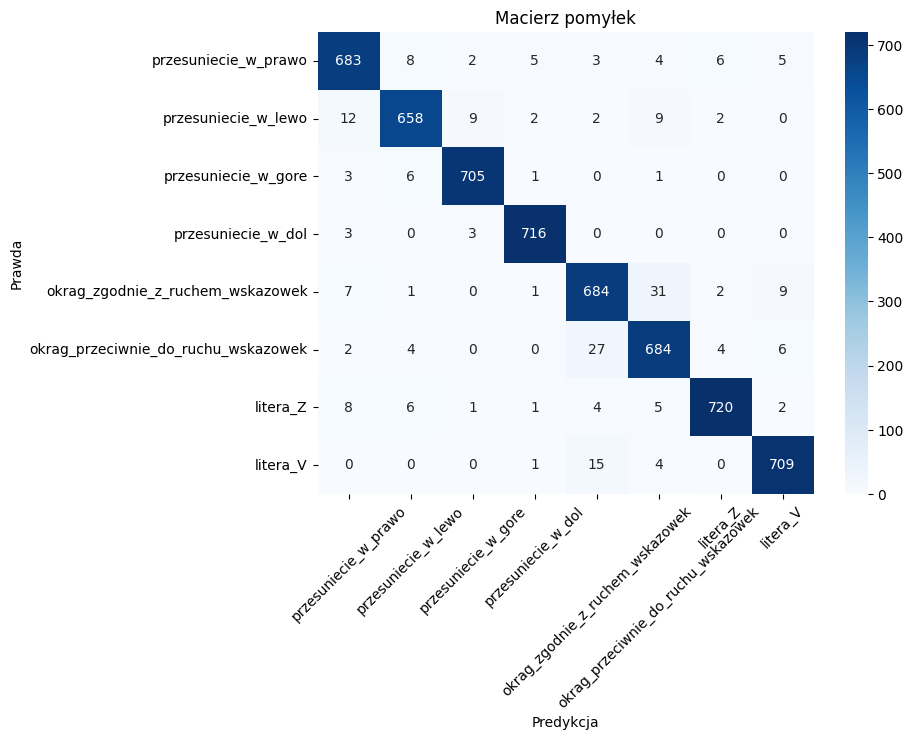

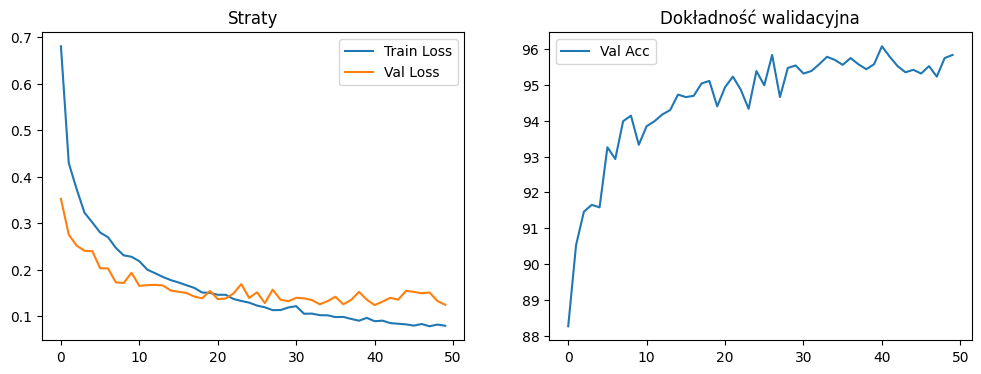

In [50]:
# 12. Wizualizacja: macierz pomyłek i historia trenowania
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=GESTURES, yticklabels=GESTURES, cmap='Blues')
plt.xlabel('Predykcja'); plt.ylabel('Prawda'); plt.title('Macierz pomyłek')
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.legend(); plt.title('Straty')
plt.subplot(1,2,2)
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Dokładność walidacyjna')
plt.show()


In [54]:
def export_model_to_onnx(model_path=None, output_path=None):
    """
    Eksportuje wytrenowany model CNN-LSTM do formatu ONNX

    Args:
        model_path: Ścieżka do zapisanego modelu (jeśli None, użyje aktualnie wytrenowanego)
        output_path: Ścieżka wyjściowa (domyślnie: gesture_model.onnx)

    Returns:
        Ścieżka do pliku ONNX lub None w przypadku błędu
    """
    import torch
    import os

    # Ustawienie domyślnej ścieżki wyjściowej
    if output_path is None:
        # output_path = "/content/drive/MyDrive/gesture_model.onnx"
        output_path = "/content/gesture_model.onnx"

    try:
        # Jeśli podano ścieżkę do modelu, załaduj go
        if model_path is not None:
            # model_to_export = CNN_LSTM(in_channels=3, hidden_size=64, n_classes=len(GESTURES))
            model_to_export = SimpleCNN(in_channels=3, n_classes=len(GESTURES))
            model_to_export.load_state_dict(torch.load(model_path, map_location='cpu'))
            print(f"✅ Załadowano model z: {model_path}")
        else:
            # Użyj aktualnie wytrenowanego modelu
            model_to_export = model
            print("✅ Używam aktualnie wytrenowanego modelu")

        # Ustawienie w tryb inferencji
        model_to_export.eval()
        model_to_export = model_to_export.cpu()  # Przenieś na CPU

        # Utworzenie przykładowego wejścia
        # Dla CNN-LSTM: (batch_size, sequence_length, features)
        # dummy_input = torch.randn(1, SEQUENCE_LENGTH, 3)

        # Dla CNN-MLP
        dummy_input = torch.randn(1, 3, 80)

        print(f"🔧 Kształt wejścia: {dummy_input.shape}")
        print(f"📊 Parametry modelu:")
        print(f"   - Sequence length: {SEQUENCE_LENGTH}")
        print(f"   - Input channels: 3")
        print(f"   - Hidden size: 64")
        print(f"   - Number of classes: {len(GESTURES)}")
        print(f"   - Classes: {GESTURES}")

        # Test forward pass
        with torch.no_grad():
            test_output = model_to_export(dummy_input)
            print(f"✅ Test forward pass: {test_output.shape}")

        # Eksport do ONNX
        print(f"🚀 Rozpoczynam eksport do ONNX...")

        torch.onnx.export(
            model_to_export,                    # Model do eksportu
            dummy_input,                        # Przykładowe dane wejściowe
            output_path,                        # Ścieżka do pliku ONNX
            export_params=True,                 # Eksportuj wagi modelu
            opset_version=11,                   # Wersja ONNX (11 jest najbezpieczniejsza dla STM32)
            do_constant_folding=True,           # Optymalizacja stałych
            input_names=['accelerometer_data'], # Nazwa wejścia
            output_names=['gesture_prediction'], # Nazwa wyjścia
            # dynamic_axes={                      # Dynamiczne osie (opcjonalne)
            #     'accelerometer_data': {0: 'batch_size'},
            #     'gesture_prediction': {0: 'batch_size'}
            # },
            dynamic_axes=None,
            verbose=False                       # Szczegółowe logi
        )

        # Sprawdzenie rozmiaru pliku
        file_size = os.path.getsize(output_path) / 1024  # KB
        print(f"✅ Model wyeksportowany pomyślnie!")
        print(f"📁 Plik: {output_path}")
        print(f"📏 Rozmiar: {file_size:.2f} KB")

        # Zapisanie metadanych modelu
        metadata = {
            'sequence_length': SEQUENCE_LENGTH,
            'input_channels': 3,
            'hidden_size': 64,
            'num_classes': len(GESTURES),
            'gestures': GESTURES,
            'overlap_ratio': OVERLAP_RATIO
        }

        metadata_path = output_path.replace('.onnx', '_metadata.json')
        import json
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"📋 Metadane zapisane: {metadata_path}")

        return output_path

    except Exception as e:
        print(f"❌ Błąd podczas eksportu: {e}")
        import traceback
        print(f"🔍 Szczegóły błędu:\n{traceback.format_exc()}")
        return None

# Funkcja weryfikacji eksportu
def verify_onnx_export(onnx_path):
    """
    Weryfikuje poprawność eksportu porównując wyniki PyTorch vs ONNX
    """
    try:
        import onnxruntime as ort
        import numpy as np

        print("🔍 Weryfikacja eksportu ONNX...")

        # 1. Załaduj oryginalny model PyTorch na CPU
        # Upewnij się, że ta instancja modelu jest na CPU, tak jak w pętli walidacyjnej
        model.eval()
        model.cpu()

        # 2. Przygotuj sesję ONNX Runtime
        ort_session = ort.InferenceSession(onnx_path)
        input_name = ort_session.get_inputs()[0].name
        output_name = ort_session.get_outputs()[0].name

        # 3. Przygotuj przykładowe dane wejściowe JAKO TENSOR PYTORCH
        test_input_tensor = torch.randn(1, 3, 80)

        # 4. Wykonaj inferencję przez PyTorch (model i dane na CPU)
        with torch.no_grad():
            pytorch_output = model(test_input_tensor).numpy()

        # 5. Wykonaj inferencję przez ONNX (teraz konwertuj na NumPy)
        onnx_input = {input_name: test_input_tensor.numpy()}
        onnx_output = ort_session.run([output_name], onnx_input)[0]

        print(f"ONNX output shape: {onnx_output.shape}")

        # 6. Porównanie wyników
        max_diff = np.abs(pytorch_output - onnx_output).max()
        print(f"🔍 Maksymalna różnica między PyTorch a ONNX: {max_diff:.2e}")

        if max_diff < 1e-5:
            print("✅ Eksport zweryfikowany - modele są identyczne")
            return True
        else:
            print("⚠️ Wykryto różnice między modelami")
            return False

    except Exception as e:
        print(f"❌ Błąd weryfikacji: {e}")
        return False


In [55]:
!pip install onnx onnxruntime --quiet

In [56]:
# Eksport najlepszego modelu do ONNX
print("=" * 60)
print("EKSPORT MODELU DO ONNX")
print("=" * 60)

# Opcja 1: Eksport aktualnie wytrenowanego modelu
# onnx_path = export_model_to_onnx()

# Opcja 2: Eksport z zapisanego pliku (jeśli chcesz użyć konkretnego pliku)
onnx_path = export_model_to_onnx('/content/best_model.pth')

if onnx_path:
    print("\n" + "=" * 60)
    print("WERYFIKACJA EKSPORTU")
    print("=" * 60)

    # Zainstaluj onnxruntime jeśli potrzeba
    try:
        import onnxruntime
    except ImportError:
        print("Instaluję onnxruntime...")
        !pip install onnxruntime

    # Weryfikuj eksport
    verify_onnx_export(onnx_path)

    print("\n" + "=" * 60)
    print("GOTOWE!")
    print("=" * 60)
    print(f"📁 Plik ONNX: {onnx_path}")
    print("🎯 Model gotowy do importu w X-CUBE-AI")


EKSPORT MODELU DO ONNX
✅ Załadowano model z: /content/best_model.pth
🔧 Kształt wejścia: torch.Size([1, 3, 80])
📊 Parametry modelu:
   - Sequence length: 80
   - Input channels: 3
   - Hidden size: 64
   - Number of classes: 8
   - Classes: ['przesuniecie_w_prawo', 'przesuniecie_w_lewo', 'przesuniecie_w_gore', 'przesuniecie_w_dol', 'okrag_zgodnie_z_ruchem_wskazowek', 'okrag_przeciwnie_do_ruchu_wskazowek', 'litera_Z', 'litera_V']
✅ Test forward pass: torch.Size([1, 8])
🚀 Rozpoczynam eksport do ONNX...
✅ Model wyeksportowany pomyślnie!
📁 Plik: /content/gesture_model.onnx
📏 Rozmiar: 446.25 KB
📋 Metadane zapisane: /content/gesture_model_metadata.json

WERYFIKACJA EKSPORTU
🔍 Weryfikacja eksportu ONNX...
ONNX output shape: (1, 8)
🔍 Maksymalna różnica między PyTorch a ONNX: 3.81e-06
✅ Eksport zweryfikowany - modele są identyczne

GOTOWE!
📁 Plik ONNX: /content/gesture_model.onnx
🎯 Model gotowy do importu w X-CUBE-AI


In [11]:
# === Komórka do obliczenia parametrów StandardScaler dla kodu C ===

print("=" * 60)
print("OBLICZANIE PARAMETRÓW SCALERA DLA ZBIORU TRENINGOWEGO")
print("=" * 60)

try:
    from sklearn.preprocessing import StandardScaler

    # 1. Uzyskanie dostępu do danych treningowych na podstawie indeksów
    # Zakładamy, że zmienne 'X' i 'train_ds' istnieją z poprzednich komórek
    train_indices = train_ds.indices
    X_train = X[train_indices]
    print(f"Pobrano {len(X_train)} sekwencji treningowych.")

    # 2. Przekształcenie danych do formatu (liczba_próbek, liczba_cech)
    # Kształt wejściowy: (sekwencje, kanały, długość) -> (sekwencje, 80, 3)
    # Kształt docelowy: (sekwencje * 80, 3)
    X_train_reshaped = X_train.transpose(0, 2, 1).reshape(-1, 3)
    print(f"Przekształcono zbiór do kształtu: {X_train_reshaped.shape} do analizy.")

    # 3. Utworzenie i dopasowanie jednego, globalnego scalera
    global_scaler = StandardScaler()
    global_scaler.fit(X_train_reshaped)
    print("✅ Scaler został pomyślnie dopasowany do danych treningowych.")

    # 4. Wyświetlenie wartości gotowych do wklejenia w kodzie C
    print("\n" + "=" * 60)
    print("👇 SKOPIUJ I WKLEJ PONIŻSZY KOD DO PLIKU main.c 👇")
    print("=" * 60)
    print(f"const float mean_values[3] = {{ {global_scaler.mean_[0]:.6f}f, {global_scaler.mean_[1]:.6f}f, {global_scaler.mean_[2]:.6f}f }};")
    print(f"const float scale_values[3] = {{ {global_scaler.scale_[0]:.6f}f, {global_scaler.scale_[1]:.6f}f, {global_scaler.scale_[2]:.6f}f }};")
    print("=" * 60)

except NameError as e:
    print(f"\n❌ BŁĄD: Nie znaleziono wymaganej zmiennej: {e}")
    print("Upewnij się, że komórki z definicją 'X' oraz podziałem na 'train_ds' zostały wykonane.")
except Exception as e:
    print(f"\n❌ Wystąpił nieoczekiwany błąd: {e}")



OBLICZANIE PARAMETRÓW SCALERA DLA ZBIORU TRENINGOWEGO
Pobrano 23142 sekwencji treningowych.
Przekształcono zbiór do kształtu: (1851360, 3) do analizy.
✅ Scaler został pomyślnie dopasowany do danych treningowych.

👇 SKOPIUJ I WKLEJ PONIŻSZY KOD DO PLIKU main.c 👇
const float mean_values[3] = { -0.042107f, -0.003919f, 0.030614f };
const float scale_values[3] = { 0.976296f, 0.951129f, 0.977828f };
